# Introduction to Logistic Regression

-----

In previous notebooks, we have seen how to perform linear regression on input data to predict a continuous value. In some cases, however, we wish to predict a categorical value, such as _True/False_ or _Yes/No_. Traditional regression methods are not optimal for these problems, since this requires the prediction of a discrete and not continuous value. In this notebook we introduce a technique that simulates linear regression, but with an additional function employed that maps the continuous value predicted by linear regression methods into a **probability**, or specifically the range $[0, 1]$. In this manner, we can apply a threshold to this probability to predict a binary response.

While several functions might be suitable for this transformation, the most popular
function is the [_logit_ function][wlf]. Note that some older analyses might reference the [_probit_ function][wpf]. Performing regression by using the logit function is known as _[logistic regression][wlr]_ (the inverse of the logit function is known as the [_logistic_ function][wlcf]). The name might seem confusing since technically this algorithm is used to perform classification, but since logistic regression borrows heavily in its approach from linear regression, the descriptive name was maintained. A major benefit of logistic regression is the creation of a parametric model that can be explored to understand why predictions are made, in the same manner as a linear regression model.

In this notebook, we introduce the logit function and how it can be used to construct a binary model. Next, we introduce logistic regression, and specifically show how logistic regression can be performed by using estimators from the scikit-learn library. We also introduce several popular performance metrics and show how they can be calculated for binary classification tasks.

-----
[wlr]: https://en.wikipedia.org/wiki/Logistic_regression
[wlf]: https://en.wikipedia.org/wiki/Logit
[wpf]: https://en.wikipedia.org/wiki/Probit
[wlcf]: https://en.wikipedia.org/wiki/Logistic_function

## Table of Contents

[Formalism](#Formalism)

- [Logit Function](#Logit-Function)
- [Gradient Descent](#Gradient-Descent)
- [Logistic Modelling](#Logistic-Modelling)

[Logistic Regression: Adult Data](#LogisticRegression:-Adult-Data)
- [Data Preparation](#Data-Preparation)
- [LogisticRegression Model](#LogisticRegression-Model)

[Classification Performance Metrics](#Classification-Performance-Metrics)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

-----

In a binary classification process, we have two possible outcomes, which for the sake of generality, we can label as _Success_ or _Failure_. Denoting the probability of these two outcomes as $P(S)$ and $P(F)$ respectively, we can write the probability of success as $P(S) = p$, and the probability of failure as $P(F) = 1 - p$. Thus, the odds of a successful outcome, which is the ratio of the probability of success to the probability of failure, is given by the following expression:

$\textrm{Odds}(S) = \frac{p}{1 - p}$

We can extend the framework of _linear regression_ to the task of binary classification by employing a mapping between the continuous value predicted by a linear regressor and the probability of an event occurring, which is bounded by the range $[0, 1]$. To do this, we need a function that maps the real numbers into this range, which enables a regression onto a set of discrete values (0 or 1) that provides us the binary classification. One popular choice for this function is the _logit_ function, while another choice is the _probit_ function. The use of these functions for a classification task leads to _logistic regression_ or _probit regression_. While we focus in this notebook on the application of logistic regression for the binary classification task, this approach can be generalized to classify into more than two categories, this more advanced technique is known as [multinomial logistic regression][mlr].

-----

[mlr]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

[[Back to TOC]](#Table-of-Contents)

### Logit Function

$\DeclareMathOperator\erf{erf}$

The [_logit_ function][wl] is defined as the logarithm of the odds (i.e, $p/(1 - p)$), which is also known as the _log-odds_. Thus, the _logit_ function can be written for a probability of success $p$:

$\textrm{logit}(p) = \log\left(\frac{p}{1 - p}\right)$ where $0 \leq p \leq 1$. 

We can invert this relationship to obtain the [_logistic_ function][wlf], which for a parameter $\alpha$ is defined by the following expression:

$\textrm{logit}^{-1}(\alpha) = \textrm{logistic}(\alpha) = \frac{1}{1 + \exp{(-\alpha})}$

The logit function (and the probit function) is an _S_ shaped curve that converts real numbers into a probability. Both the logit and probit functions are related to the *sigmoid* function, but are centered at the origin (0, 0). In the following Code cell, we plot the $\textrm{logistic}$ function, or the inverse of the logit function, demonstrating how the real numbers can be mapped into the range $[0, 1]$.

**Note:** You are not required to understand the code in the next Code cell. Just pay attention to the plot and visualize how real numbers are mapped into [0,1] range.

-----
[wl]: https://en.wikipedia.org/wiki/Logit
[wp]: https://en.wikipedia.org/wiki/Probit
[wlf]: https://en.wikipedia.org/wiki/Logistic_function
[wef]: https://en.wikipedia.org/wiki/Error_function
[mlr]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

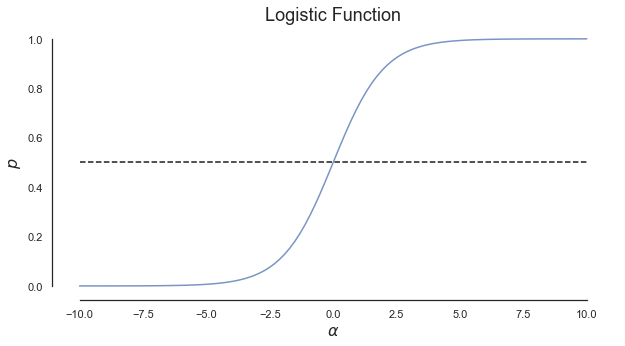

In [2]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Compute and plot logistic function
x = np.linspace(-10, 10, 100)
y = 1. / (1 + np.exp(-x))
ax.plot(x, y, alpha=0.75)

# Draw probability barrier
ax.hlines(0.5, -10, 10, linestyles='--')

# Decorate plot
ax.set_xlabel(r'$\alpha$', fontsize=16)
ax.set_ylabel(r'$p$', fontsize=16)
ax.set_title('Logistic Function', fontsize=18)
sns.despine(offset = 2, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

### Logistic Modeling

Before introducing logistic regression, we first show how the logistic function can be used to model binary response data. For this purpose, we will use data from NASA on the relationship between the outside temperature when the space shuttle was launched, and the occurrence of a thermal failure of an O-ring on a booster rocket. We will use this data to create a predictive model between temperature and thermal failure (note that it is believed that the [failure of an O-ring][wsrb] on a solid rocket booster led to the Challenger disaster).

We will bypass the logistic regression process and instead explain the concept with two images. The first image is the O-ring test result conducted by NASA. The test recorded the number of O-ring failures under different temperature. The [actual data][ord] we use is hosted at the University of California at Irvine (UCI) machine learning data repository.

<img src="images/m2_challenger.png" width="800">

We can apply logistic regression on this data. The independent variable is temperature. The dependent variable will be whether there's at least one failure, 1 if yes, 0 if no.

The cost (or loss) function for logistic regression is the sum of the squared errors between the actual classes and the predicted classes

After we apply logistic function and minimize the cost function, we will get a sigmoid curve which is also our predictive model like this:

<img src="images/sigmoid.png" width="600">


-----
[wsrb]: https://en.wikipedia.org/wiki/Space_Shuttle_Solid_Rocket_Booster#Challenger_disaster
[ord]: https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/


Given this predictive model, we can predict for new, unseen data. In this case, we can predict the probability of thermal failure for a given temperature. We can see that the probability of at least one O-ring failure is about 50% when temperature is 65 degree Fahrenheit. The temperature at launch during the Challenger disaster was 31 degrees Fahrenheit!



-----

[[Back to TOC]](#Table-of-Contents)

## LogisticRegression: Adult Data

-----

We now will use the `LogisticRegression` estimator in the scikit-learn library to construct a logistic regression model. This estimator accepts several hyperparameters, of which the most important for our purposes include:

- `C`: Inverse of regularization strength, larger `C` reduces overfitting risk.
- `class_weight`: Weights to be applied to classes when performing regression, default is uniform
- `fit_intercept`: Specifies if a constant term should be included in the regression, the default is `True`
- `random_state`: The seed used to initialize the random number generator, a constant value ensures reproducibility.

Run `help(LogisticRegression)` to view more details about the model and the hyper parameters.


------

In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1E6)

-----

### Data Preparation

We now turn to a rather complex data set with which to perform logistic regression. The data we will explore next is the adult income prediction data. These data were extracted by Barry Becker from the 1994 Census database and consist of the following features: age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, and salary. Of these, only five are continuous:  fnlwgt, education-num, capital-gain, capital-loss, and hours-per-week; the others are discrete. The last column, salary, is discrete and contains one of two strings to indicate if the salary was below or above $50,000. This is the column we will use to make our label.

The data we use is a subset of original data which can be found in the [UCI Machine Learning Repository][uciad].

We first use the pandas `read_csv` function to read the data file. Once the DataFrame is created, we randomly sample five rows to verify that the data has been successfully read.

Next, we display basic information and descriptive statistics of the dataframe to get more understanding of our data.

Next, we encode out target column `Salary` to create a numeric label. We use `value_counts()` to check class balance of the label.

Finally, we use patsy module to create dependent and independent variables from the dataframe.

-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [4]:
# Read CSV data
adult_data = pd.read_csv('data/adult_income.csv')

# Display random sample
adult_data.sample(5)

,Age,Workclass,FNLWGT,Education,EducationLevel,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Salary
3951,59,Private,193895,Some-college,10,Widowed,Adm-clerical,Not-in-family,White,Female,0,0,35,United-States,<=50K
3320,41,Private,529216,Bachelors,13,Divorced,Tech-support,Unmarried,Black,Male,7430,0,45,?,>50K
1291,24,Private,258700,5th-6th,3,Never-married,Farming-fishing,Other-relative,Black,Male,0,0,40,Mexico,<=50K
991,46,Private,265097,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,5,United-States,<=50K
1907,35,Local-gov,668319,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1740,80,United-States,<=50K


-----

The data sample displayed by the previous Code cell does not indicate any problems with the data that must be fixed; but to ensure the data are clean, we first check if there's missing data with DataFrame `info` function, then compute and display summary statistics by using the `describe` function.

-----

In [5]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
Age               4000 non-null int64
Workclass         4000 non-null object
FNLWGT            4000 non-null int64
Education         4000 non-null object
EducationLevel    4000 non-null int64
MaritalStatus     4000 non-null object
Occupation        4000 non-null object
Relationship      4000 non-null object
Race              4000 non-null object
Sex               4000 non-null object
CapitalGain       4000 non-null int64
CapitalLoss       4000 non-null int64
HoursPerWeek      4000 non-null int64
NativeCountry     4000 non-null object
Salary            4000 non-null object
dtypes: int64(6), object(9)
memory usage: 468.9+ KB


The information of the adult data shows that there's no missing data in all columns. Next we check the descriptive statistics of numerical data.

In [6]:
# Display descriptive statistics
adult_data.describe()

,Age,FNLWGT,EducationLevel,CapitalGain,CapitalLoss,HoursPerWeek
count,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000
mean,38.463500,1.888918e+05,10.057750,1087.994500,86.308500,40.413000
std,13.778775,1.075761e+05,2.564383,7633.716387,401.559989,12.427693
min,17.000000,1.487800e+04,1.000000,0.000000,0.000000,1.000000
25%,27.000000,1.167880e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783395e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.345628e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.268339e+06,16.000000,99999.000000,4356.000000,99.000000


-----

The descriptive statistics indicate that the numerical columns all contain valid data, and that the ranges seem to be  reasonable. At this point, in a real-world problem we would also explore the categorical features; for example, checking the count of distinct values in a categorical column. In this case, however, we can proceed to the next step, where we define our label feature. This data is generally used to test classification algorithms, as the data include a _Salary_ column that includes one of two entries: `<=50K` or `>50K` to indicate if the individual's salary is less than or equal to \\$50,000 or if the individual's salary exceeds \\$50,000. 

To apply a machine learning algorithm to these data, we need to generate a numerical label that maps to these two values. For this, we create a new column in our DataFrame called `Label` and map the original column to $1$ if the `Salary` feature is equal to `>50K` and $0$ otherwise. This step is done in the following Code cell, where we map a lambda function onto the `Salary` feature to create this new feature. You can also use `LabelEncoder` introduced in the previous lesson, however, `LabelEncoder` maps categorical values to numbers based on alphabetical order instead. In this case we use `map` function to explicitly map `'<=50K'` to 0 and `'>50K'` to 1. The second Code cell compares the original `Salary` feature to our new `Label` feature by randomly sampling five instances to ensure this task was completed successfully.

-----

In [7]:
# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)
# Display label and original column for comparison
adult_data[['Salary', 'Label']].sample(5)

,Salary,Label
321,<=50K,0
2696,>50K,1
166,>50K,1
1681,<=50K,0
2547,<=50K,0


-----

With our new `Label` feature, we can compute what is known as the *zero model*, in which we classify the data by always predicting the majority class. While we do not do this in practice since the model provides no predictive power or insights into the data, this does set a useful baseline for how well an algorithm should perform. Any model that performs worse or similar to the _zero model_ should be discarded. Instead, we will want to perform better than this value. In this case, the majority class is 0, our zero model performs at a 77.1% classification accuracy, which indicates that our data set is unbalanced since we have roughly three lower salary instances to every higher salary instance.

-----

In [8]:
#count of each class in Label column
adult_data.Label.value_counts()

0    3084
1     916
Name: Label, dtype: int64

In [9]:
#zero model
zm = float(adult_data.Label.value_counts()[0]/(adult_data.Label.value_counts()[0]+adult_data.Label.value_counts()[1]))
print(f'Zero Model Performance = {100.0 * zm:4.1f}%')

Zero Model Performance = 77.1%


-----

With our target label constructed, we now create the independent and dependent variables that we will use to construct the logistic regression model. 

In the following Code cell, we use patsy model to create independent and dependent variables. We select 4 columns as the independent variable. Among them, `Age`, `HoursPerWeek` and `CapitalGain` are continuous features; `Sex` is categorical feature.

Feature selection is an important topic and we will discuss it in more details in future lessons. For now we will just pick these columns for demonstration purpose.

-----

In [10]:
import patsy as pts 

# Create dependent and independent variables
y, x = pts.dmatrices('Label ~ Age + HoursPerWeek + CapitalGain + C(Sex)', data=adult_data, return_type='dataframe')

In [11]:
x.head()

,Intercept,C(Sex)[T. Male],Age,HoursPerWeek,CapitalGain
0,1.0,1.0,62.0,40.0,0.0
1,1.0,1.0,50.0,40.0,0.0
2,1.0,1.0,36.0,50.0,0.0
3,1.0,0.0,64.0,40.0,0.0
4,1.0,1.0,28.0,60.0,0.0


-----

### LogisticRegression Model

With our feature and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first create our logistic regression classifier, and then measure its performance on our training data. In the first Code cell, we start by splitting our data into training and testing samples. Since we have over 30,000 instances in our data set, our standard 60%:40% split should be sufficient. Next, we create the `LogisticRegression` estimator. The only hyperparameter that we specify at this time is  `C` in order to reduce the impact of regularization. Next, we fit this estimator to our training data, and generate an accuracy score on our test data. 

In the second Code cell, we compute and display a simple accuracy score before generating and displaying the full classification report. In the next Code cells, we define a function `confusion`, then use the function to plot the confusion matrix. Our logistic regression performs a little better than the zero model. The report indicates that our model performs worst in predicting the high income class(or 1). Specifically, the low recall rate of high income(class 0) indicates that we incorrectly label majority of high income targets as low income. This could prove problematic, for example, if we are seeking to target high wage earners in a marketing campaign.

----

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=23)

adult_model = LogisticRegression(C=1E6)
adult_model = adult_model.fit(x_train, y_train)

In [13]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(x_test)
score = 100.0 * metrics.accuracy_score(y_test, predicted)
print(f'Logistic Regression [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:')
print(metrics.classification_report(y_test, predicted))

Logistic Regression [Adult Data] Score = 79.0%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88      1211
         1.0       0.74      0.21      0.33       389

    accuracy                           0.79      1600
   macro avg       0.77      0.59      0.60      1600
weighted avg       0.78      0.79      0.74      1600



In [14]:
# This method produces a colored heatmap that displays the relationship
# between predicted and actual types from a machine learning method.

def confusion(test, predict, labels, title='Confusion Matrix'):
    '''
        test: true label of test data, must be one dimensional
        predict: predicted label of test data, must be one dimensional
        labels: list of label names, ie: ['positive', 'negative']
        title: plot title
    '''

    bins = len(labels)
    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=labels, columns=labels )
    
    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")    
    hm.axes.set_title(title, fontsize=20)
    hm.axes.set_xlabel('Predicted', fontsize=18)
    hm.axes.set_ylabel('Actual', fontsize=18)

    return None

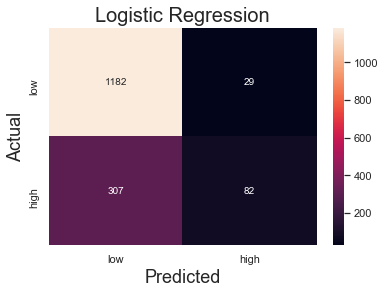

In [15]:
confusion(y_test['Label'], predicted, ['low', 'high'], title='Logistic Regression')

[[Back to TOC]](#Table-of-Contents)

## Classification Performance Metrics

There are many ways to measure the performance of a classification model. In the above code, to evaluate the model, we printed the accuracy score, the classification report which has precision, recall and f1-score, and plotted the confusion matrix. We will discuss these terms briefly below.

Classification performance metrics are a very import concept. We will explore them in more details in future lessons.

#### Accuracy Score
Accuracy score is the proportion of correct predictions.  
From the confusion matrix, the correct low income prediction is 1182, correct high income prediction is 82, so the accuracy score is (1182 + 82)/(1182+82+307+29)=0.79.

#### Precision
Precision is the proportion of the prediction that is actually correct.  
From the confusion matrix, 1182+307 are predicted as low income, among them, 1182 are actual low income, so the precision of low income(or 0) is 1182/(1182+307)=0.79.  
The precision of high income(or 1) is 82/(82+29)= 0.74. 

#### Recall
Recall is the proportion of actual class of a label that is identified correctly.
From the confusion matrix, actual number of low income is 1182+2, (among them 1182 are correctly identified as low income), so the recall of low income (or 0) is 1182/(1182+29)=0.98.  
The recall of high income (or 1) is 82/(307+82)=0.21

#### f1-score
f1-score is a harmonic mean of Precision and Recall.  
The low f1-score on high income(or 1) indicates that the model did a bad job on predicting high income.

#### Support
Support is the number of occurrences of each particular class in the true responses (responses in your test set). You can calculate it by summing the columns of the confusion matrix.

#### Confusion Matrix
A confusion matrix is a specific table layout that allows visualization of the performance of an algorithm.

In the confusion matrix above, y axis represents actual values of test label and x axis represents predicted values.  
The first row of the confusion matrix shows count of true low income, which is 1182 + 29, among which 1182 are correctly predicted as low income and 29 are wrongly predicted as high income.  
The second row of the confusion matrix shows count of true high income, which is 307 + 82, among which 307 are wrongly predicted as low income and 82 are correctly predicted as high income.

-----


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used logistic regression to predict if a person earns high income or low income from the `Age`, `HoursPerWeek`, `CapitalGain` and categorical `Sex` features. In the empty Code cell below, repeat this process, but add more features to independent variables, such as `Relationship` or `Race`. Has the prediction performance improved?

-----

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Wikipedia article on [Logistic Regression][1]
1. An interesting blog article on performing [logistic regression][2] in Python
2. An implementation of [logistic regression][3] for modeling usage of wells in remote locations
5. A demonstration of logistic regression for [loan prediction][6]
67. A concise discussion on [performance metrics][pm] for classification algorithms
-----

[1]: https://en.wikipedia.org/wiki/Logistic_regression
[2]: http://blog.yhat.com/posts/logistic-regression-and-python.html
[3]: http://slendermeans.org/arm-ch5.html
[6]: http://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/B3.%20Logistic%20Regression%20-%20Analysis.ipynb
[pm]: http://mrvar.fdv.uni-lj.si/pub/mz/mz3.1/vuk.pdf

**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 